<a href="https://colab.research.google.com/github/AutoResearch/EEG-GAN/blob/3-release-as-pip-package/docs/Tutorials/Tutorial_AEGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Tutorial

---
---

# Augmenting EEG with Generative Adversarial Networks<br>

---
---

We here use Generative Adversarial Networks (GANs) to create trial-level synthetic EEG samples. We can then use these samples as extra data to train whichever classifier we want to use (e.g.,  Support Vector Machine, Neural Network).

GANs are machine learning frameworks that consist of two adversarial neural network agents, namely the generator and the discriminator. The generator is trained to create novel samples that are indiscernible from real samples. In the current context, the generator produces realistic continuous EEG activity, conditioned on a set of experimental variables, which contain underlying neural features representative of the outcomes being classified. For example, depression manifests as increased alpha oscillatory activity in the EEG signal, and thus, an ideal generator would produce continuous EEG that includes these alpha signatures. In contrast to the generator, the discriminator determines whether a given sample is real or synthetically produced by the generator. The core insight of GANs is that the generator can effectively learn from the discriminator. Specifically, the generator will consecutively produce more realistic synthetic samples with the goal of “fooling” the discriminator into believing them as real. Once it has achieved realistic samples that the discriminator cannot discern, it can be used to generate synthetic data—or in this context, synthetic EEG data.

The dataset provided is a subset of data from Williams et al., 2021 (*Psychophysics*). In this study, participants completed a two-armed bandit gambling task where they needed to discern which of two coloured squares were more often rewarding through trial-and-error. Each trial presented two coloured squares that the participants were to choose from, and provided performance feedback as “WIN” or “LOSE”, yielding two conditions of interest. For each pair of squares, one had a win rate of 60% while the other had a win rate of 10%. Participants saw each pair of colours twenty times consecutively. There were a total of five pairs of squares (with colours randomly determined), resulting in one hundred trials per participant. This paradigm elicits well-known frontal neural differences when contrasting the win and lose outcomes, namely in the reward positivity, delta oscillations, and theta oscillations (see Williams et al., 2021; Psychophysics).

In this tutorial, we will classify the WIN and LOSE conditions using both Support Vector Machine and Neural Network classifiers. We will:
1. Train a GAN on trial-level EEG data
2. Generate synthetic EEG data
3. Create an augmented EEG dataset
4. Determine classification performance using both the empirical and augmented datasets
    - Empirical Dataset: We train the classifer on the empirical data that was used to train the GANs
    - Augmented Dataset: We train the classifer on the empirical data with the appended synthetic samples

---
---
## Evaluation of EEG-GAN
**Enhancing EEG Data Classification Across Diverse Contexts Using Generative Adversarial Networks**<br>
$Williams$, $Weinhardt$, $Hewson$, $Plomecka$, $Langer$, & $Musslick$ (*in prep, 2024*)<br>

**Augmenting EEG with Generative Adversarial Networks Enhances Brain Decoding Across Classifiers and Sample Sizes**<br>
$Williams$, $Weinhardt$, $Wirzberger$, & $Musslick$ (*Proceedings of the Annual Meeting of the Cognitive Science Society, 2023*)<br>

---
---
## Table of Contents
    Step 0. Installing and Loading Modules
        Step 0.1. Installing Modules
        Step 0.2. Loading Modules
    Step 1. EEG Data
        Step 1.1. Load Data
        Step 1.2. View Data
    Step 2. AE-GAN
        Step 2.1. Exploring the EEG-GAN Package Functions
            Step 2.1.1. GAN Training Help
            Step 2.1.2. AE Training Help
            Step 2.1.3. Visualize Help
            Step 2.1.4. Generate Samples Help
        Step 2.2.A Training the AE-GAN
        Step 2.2.B Training the GAN (Optional)
        Step 2.3. Visualizing GAN Losses
        Step 2.4. Generating Synthetic Data
    Step 3. Synthetic Data
        Step 3.1. Load Data
        Step 3.2. View Data
            Step 3.2.1. View Trial-Level Data
            Step 3.2.2. View ERP Data
    Step 4. Classification Setup
        Step 4.1. Preparing Validation Data
        Step 4.2. Preparing Empirical Data
        Step 4.3. Preparing Augmented Data
    Step 5. Support Vector Machine
        Step 5.1. Define Search Space
        Step 5.2. Classify Empirical Data
        Step 5.3. Classify Augmented Data
    Step 6. Neural Network
        Step 6.1. Define Search Space
        Step 6.2. Classify Empirical Data
        Step 6.3. Classify Augmented Data
    Step 7. Final Report
        Step 7.1. Present Classification Performance
        Step 7.2. Plot Classification Performance

*Note: you can also view an interactive table of contents in your sidebar*

# Step 0. Installing and Loading Modules

## Step 0.1. Installing Modules
We will now download and install the EEG-GAN package


In [1]:
!pip install eeggan

# Step 0.2. Loading Modules

In [2]:
#Load other modules specific to this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
from scipy import signal
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

#Create a print formatting class
class printFormat:
    bold = '\033[1m'
    italic = '\033[3m'
    end = '\033[0m'

!eeggan setup_tutorial

eeggan_training_example.csv has been downloaded and saved to directory data.
eeggan_validation_example.csv has been downloaded and saved to directory data.
pretrained_autoencoder.pt has been downloaded and saved to directory trained_ae.
pretrained_gan.pt has been downloaded and saved to directory trained_models.
EEG-GAN tutorial files have been downloaded.


# Step 1. EEG Data

## Step 1.1. Load Data
We will load the provided EEG training data and print some information about what this contains. Note that this is not necessary for the `eeggan` package, which will load the file itself during training. However, it is useful to understand the data structure but also this data will be used later in the classification task.

In [3]:
#Load the data
empiricalHeaders = np.genfromtxt('data/eeggan_training_example.csv', delimiter=',', names=True).dtype.names
empiricalEEG = np.genfromtxt('data/eeggan_training_example.csv', delimiter=',', skip_header=1)

#Print the head of the data
print(printFormat.bold + 'Display Header and first few rows/columns of data\n \033[0m' + printFormat.end)
print(pd.DataFrame(empiricalEEG, columns=empiricalHeaders).iloc[:5,:6])

#Print some information about the columns
print('\n' + '-'*90)
print(f"{printFormat.bold}\nNote the first four columns:{printFormat.end}\n"
      f"    ParticipantID - Indicates different participants\n"
      f"    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified\n"
      f"    Trial - Indicates the trial number for that participant and condition\n"
      f"    Electrode - a numerical number ID of each electrode")
print('\nThe remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.\n'
      'The samples span from -200 to 1000ms around the onset of a feedback stimulus.\n'
      'These are downsampled from the original data, which contained 600 datapoints per sample.')

# Print some meta-data
print('\n' + '-'*90)
print(f"\n{printFormat.bold}Other characteristics of our data include:{printFormat.end}")
print(f"-We have {len(set(empiricalEEG[:,0]))} participants in our training set")
average_trials = round(np.mean([np.max(empiricalEEG[empiricalEEG[:,0] == pID, 2]) for pID in set(empiricalEEG[:,0])]))
std_trials = round(np.std([np.max(empiricalEEG[empiricalEEG[:,0] == pID, 2]) for pID in set(empiricalEEG[:,0])]))
print(f"-Participants have an average of {average_trials} (SD: {std_trials}) trials per outcome (win, lose)")
print(f"-There are a total of {len(empiricalEEG)} samples in our data")
print(f"-There is {len(set(empiricalEEG[:,3]))} electrode in our data")


Display Header and first few rows/columns of data
 
   ParticipantID  Condition  Trial  Electrode      Time1      Time2
0           12.0        0.0    1.0        1.0   3.457978   4.117102
1           12.0        0.0    2.0        1.0 -14.463714 -13.335952
2           12.0        0.0    3.0        1.0   6.562403   9.021622
3           12.0        0.0    4.0        1.0  -4.326536  -0.771954
4           12.0        0.0    5.0        1.0   1.140865   9.707995

------------------------------------------------------------------------------------------

Note the first four columns:
    ParticipantID - Indicates different participants
    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified
    Trial - Indicates the trial number for that participant and condition
    Electrode - a numerical number ID of each electrode

The remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.
The samples span from -200 to 1000ms around the onset of a feedback

## Step 1.2. View Data
Let's view the grand-averaged ERPs of our participants.

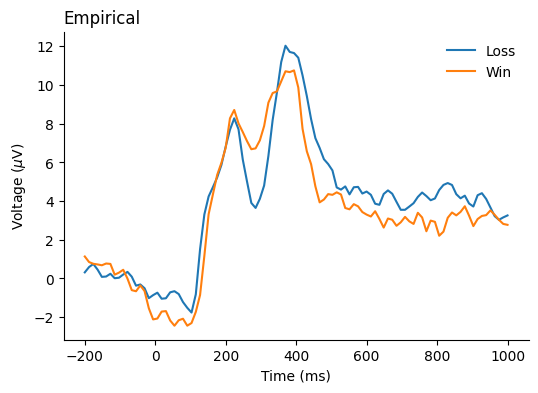

In [4]:
#Determine which rows are each condition
lossIndex = np.where(empiricalEEG[:,1]==1)
winIndex = np.where(empiricalEEG[:,1]==0)

#Grand average the waveforms for each condition
lossWaveform = np.mean(empiricalEEG[lossIndex,4:],axis=1)[0]
winWaveform = np.mean(empiricalEEG[winIndex,4:],axis=1)[0]

#Determine x axis of time
time = np.linspace(-200,1000,100)

#Setup figure
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

#Plot each waveform
ax1.plot(time, lossWaveform, label = 'Loss')
ax1.plot(time, winWaveform, label = 'Win')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Empirical', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.legend(frameon=False)

# Step 2. AE-GAN

## Step 2.1. Exploring the EEG-GAN Package Functions
<br><b>Functions</b><br>
EEG-GAN is a command line interface (CLI) package that allows users to train a Generative Adversarial Network (GAN) on EEG data. Once installed, you can run `eeggan` functions `<function>` in your terminal or command prompt alongside their parameters `<params>`:<br>
`eeggan <function> <params>`. <br><br>

`eeggan` has four functions:<br><br>
&emsp;&emsp;`gan_training` - This trains a GAN <br>
&emsp;&emsp;`autoencoder_training` - This trains an autoencoder <br>
&emsp;&emsp;`visualize` - This visualizes components of a trained GAN, such as the training losses <br>
&emsp;&emsp;`generate_samples` - This generates synthetic samples using the trained GAN<br>

<br><b>Arguments</b><br>

Each function can be followed by function parameters. Parameters are structured in that: <br>
&emsp;&emsp;Boolean arguments are passed as their argument name (e.g., `ddp`): <br>
&emsp;&emsp;&emsp;&emsp;`eeggan gan_training ddp` <br>
&emsp;&emsp;While other arguments are passed with an equals sign `=`: <br>
&emsp;&emsp;&emsp;&emsp;`eeggan gan_training data=data/eeg_training_data.csv`<br>
&emsp;&emsp; Arguments are separated by a space:<br>
&emsp;&emsp;&emsp;&emsp; `eeggan gan_training ddp data=data/eeg_training_data.csv`<br>

<br><b>Parameters</b><br>

You can use the `help` argument to see a list of possible parameters with a brief description:</b><br>
&emsp;&emsp;`eeggan gan_training help`<br>
&emsp;&emsp;`eeggan autoencoder_training help`<br>
&emsp;&emsp;`eeggan visualize help`<br>
&emsp;&emsp;`eeggan generate_samples help`<br>


### Step 2.1.1. GAN Training Help

In [5]:
!eeggan gan_training help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input            | Type            | Description                                                                              | Default value               
----------------------------------------------------------------------------------------------------------------------------------------------------
ddp              | <class 'bool'>  | Activate distributed training                                                            | False                       
seed             | <class 'bool'>  | Set seed for r

### Step 2.1.2. AE Training Help

In [6]:
!eeggan autoencoder_training help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input           | Type            | Description                                                                                   | Default value               
----------------------------------------------------------------------------------------------------------------------------------------------------
ddp             | <class 'bool'>  | Activate distributed training                                                                 | False                       
load_checkpoint | <class 'bool'>  | Load a 

### Step 2.1.3. Visualize Help

In [7]:
!eeggan visualize help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input           | Type           | Description                                                                              | Default value         
----------------------------------------------------------------------------------------------------------------------------------------------------
loss            | <class 'bool'> | Plot training loss                                                                       | False                 
average         | <class 'bool'> | Average over all samples to get 

### Step 2.1.4. Generate Samples Help

In [8]:
!eeggan generate_samples help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input                | Type           | Description                                                                                  | Default value               
----------------------------------------------------------------------------------------------------------------------------------------------------
seed                 | <class 'bool'> | Set seed for reproducibility                                                                 | None                        
model                | <class 'str'> 

## Step 2.2.A. Training the AE-GAN

The GAN within `eeggan` has two different structures dependent on whether we are training it on time-series EEG data or encoded EEG data. The former would take each of your samples as is and learn to generate them directly. The latter instead transforms each of your samples using an autoencoder and then learns to generate the encoded space. We highly suggest using the autoencoder GAN (AE-GAN) as it speeds up training and results in better generated data, but we will here show how to use both structures, starting with the AE-GAN.

Although more efficient, the drawback of using the AE-GAN is that you first need to train an autoencoder (however, training is very fast) and then you train the GAN with the `autoencoder` parameter.

We will first train our autoencoder with the following parameters:
- <b>data</b>: Determines the training dataset.
- <b>save_name</b>: Determines the autoencoder filename. This will automatically be placed within the `trained_ae` directory.
- <b>kw_channel</b>: This is used to inform the autoencoder of different electrodes.
- <b>target</b>: This informs the autoencoder which dimension should be reduced. Here we will use `time` to reduce our samples but we could also reduce our channel dimension using `channel` or both time and channel dimensions using `full`.
- <b>time_out</b>: This is the size of the reduced time dimension. For example, if your samples are 100 datapoints and this parameter is 50 datapoints, the data will be reduced to half of its size.<br>
&emsp;&emsp;-*If you are reducing the channel dimension with `target=channel` then instead use the parameter `channels_out`.*<br>
&emsp;&emsp;-*If you are reducing both dimensions with `target=full`, use both `time_out` and `channels_out`.*<br>
- <b>n_epochs</b>: Determines number of epochs to train the autoencoder.<br>
&emsp;&emsp;-*Here we only use 10 epochs to demonstrate the process but this will result in a very under-trained autoencoder. <br>
&emsp;&emsp;In Williams, Weinhardt et al., (in prep, 2024) using the AE-GAN we trained the autoencoder for 2000 epochs.*
- <b>seed</b>: Sets seed for reproducability.<br>


In [9]:
# Train Autoencoder Parameters
data = 'data/eeggan_training_example.csv'
save_name = 'my_autoencoder.pt'
kw_channel = 'Electrode'
target = 'time'
time_out = 50
n_epochs = 10
seed = 42

# Train the Autoencoder
!eeggan autoencoder_training data={data} save_name={save_name} kw_channel={kw_channel} target={target} time_out={time_out} n_epochs={n_epochs} seed={seed}

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

# Alternatively, you could have written all parameters in place:
#!eeggan autoencoder_training data='data/eeggan_training_example.csv' save_name='test_ae.pt' kw_channel='Electrode' target='time' time_out=50 n_epochs=10 seed=42


-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: data/eeggan_training_example.csv
Model save name: my_autoencoder.pt
Channel label: Electrode
Target: time
Encoded time series size: 50
Number of epochs: 10
Manual seed: True
-----------------------------------------

100% 10/10 [00:04<00:00,  2.41it/s, TRAIN LOSS: 0.022877, TEST LOSS: 0.008984]
Managing checkpoints...
Checkpoint saved to trained_ae/checkpoint.pt.
Training complete in: 00:00:04
Training finished.
Checkpoint saved to trained_ae/my_autoencoder.pt.
Training complete in: 00:00:04
Model and configuration saved in trained_ae/my_autoencoder.pt


Next, we will train the AE-GAN using the following parameters:
- <b>data</b>: Determines the training dataset
- <b>save_name</b>: Determines the GAN filename. This will automatically be placed within the `trained_models` directory.
- <b>autoencoder</b>: This points the GAN to the autoencoder that was previously trained. Including this parameter uses the AE-GAN structure, but if this parameter is not used the function will use a normal GAN structure. Again, we suggest using the AE-GAN whenever possible.
- <b>kw_condition</b>: This is used to inform the GAN of different conditions.
- <b>kw_channel</b>: This is used to inform the GAN of different electrodes.
- <b>patch_size</b>: This is the length of each token within the transformer. In other words, the time dimension will be cut into segments of this length. The `patch_size` must be a multiple of the time dimension length.<br>
&emsp;&emsp;-*The time dimension length for the AE-GAN is the embedded time length (50 in the autoencoder we trained above).*<br>
&emsp;&emsp;-*The time dimension length for the GAN is the sample length (100 in our current dataset).*<br>
&emsp;&emsp;-*So, a patch size of 10 would create 5 tokens of length 10 for the AE-GAN or 10 tokens of length 10 for the GAN.*<br>
- <b>n_epochs</b> : Determines number of epochs to train the GAN.<br>
&emsp;&emsp;-*Here we only use 10 epochs to demonstrate the process but this will result in a very under-trained GAN. <br>
&emsp;&emsp;In Williams, Weinhardt et al., (in prep, 2024) using the AE-GAN we trained the GAN for 2000 epochs.*
- <b>seed</b>: Sets seed for reproducability.<br>


*Note: If the **ddp** argument is provided, GANs will be trained using GPUs rather than CPUs*

<b>*Note: We are not here using the `my_autoencoder.pt` file that we trained, but instead are using a pretrained autoencoder `pretrained_autoencoder.pt`*</b>


In [10]:
#Train AE-GAN Parameters
data = 'data/eeggan_training_example.csv'
save_name = 'my_aegan.pt'
autoencoder = 'trained_ae/pretrained_autoencoder.pt' #Uses the pretrained autoencoder
kw_conditions = 'Condition'
kw_channel = 'Electrode'
patch_size = 10
n_epochs = 10
seed = 42

# Train the AE-GAN on CPUs
!eeggan gan_training data={data} autoencoder={autoencoder} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}

# Train the AE-GAN on GPUs
# !eeggan gan_training ddp data={data} autoencoder={autoencoder} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}
# Note, on Google Colab you can start a GPU runtime by going to Runtime > Change runtime type > Hardware accelerator > GPU

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

# Alternatively, you could have written all parameters in place:
#!eeggan gan_training data='data/eeggan_training_example.csv' autoencoder='trained_ae/test_ae.pt' save_name='demo_aegan.pt' kw_conditions='Condition' kw_channel='Electrode' patch_size=10 n_epochs=10 seed=42
#!eeggan gan_training data='data/eeggan_training_example.csv' ddp autoencoder='trained_ae/test_ae.pt' save_name='demo_aegan.pt' kw_conditions='Condition' kw_channel='Electrode' patch_size=10 n_epochs=10 seed=42



-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: data/eeggan_training_example.csv
Using autoencoder: trained_ae/pretrained_autoencoder.pt
Model save name: my_aegan.pt
Conditions: ['Condition']
Channel label: Electrode
Patch size: 10
Number of epochs: 10
Manual seed: True
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

100% 10/10 [00:35<00:00,  3.50s/it, D LOSS: -0.725763, G LOSS: 2.004391]
Managing checkpoints...
Checkpoint saved to trained_models/checkpoint.pt.
Training complete in: 00:00:35
Checkpoint saved to trained_models/my_aegan.pt.
Training complete in: 00:00:35
GAN training finished.


#Step 2.2.B. Training the GAN (Optional)

This section is **optional** as using the GAN without the autoencoder is not suggested. None-the-less, there may be situations where you want to train a GAN and not an AE-GAN and here we will show you how.

Essentially, the only difference from what we showed above in section **Step 2.2.A. Training the AE-GAN** is that:
1. We do not train an autoencoder.
2. We do not pass the `autoencoder` argument to the `gan_training` function.

In fact, below is simply the copy-paste of training the AE-GAN above but with removing the `autoencoder` parameter and changing the `save_name` so that it does not overwrite our AE-GAN model.

*Note: All sections following this one will use the AE-GAN with the corresponding `pretrained_gan.pt`.*

In [11]:
#Train GAN Parameters
data = 'data/eeggan_training_example.csv'
save_name = 'my_gan.pt'
kw_conditions = 'Condition'
kw_channel = 'Electrode'
patch_size = 10
n_epochs = 10
seed = 42

# Train the GAN on CPUs
!eeggan gan_training data={data} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}

# Train the GAN on GPUs
# !eeggan gan_training ddp data={data} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}
# Note, on Google Colab you can start a GPU runtime by going to Runtime > Change runtime type > Hardware accelerator > GPU

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

# Alternatively, you could have written all parameters in place:
#!eeggan gan_training data='data/eeggan_training_example.csv' save_name='demo_gan.pt' kw_conditions='Condition' kw_channel='Electrode' patch_size=10 n_epochs=10 seed=42
#!eeggan gan_training data='data/eeggan_training_example.csv' ddp save_name='demo_gan.pt' kw_conditions='Condition' kw_channel='Electrode' patch_size=10 n_epochs=10 seed=42



-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: data/eeggan_training_example.csv
Model save name: my_gan.pt
Conditions: ['Condition']
Channel label: Electrode
Patch size: 10
Number of epochs: 10
Manual seed: True
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

100% 10/10 [01:05<00:00,  6.55s/it, D LOSS: 2.998791, G LOSS: -1.095414]
Managing checkpoints...
Checkpoint saved to trained_models/checkpoint.pt.
Training complete in: 00:01:05
Checkpoint saved to trained_models/my_gan.pt.
Training complete in: 00:01:05
GAN training finished.


# Step 2.3. Visualizing GAN Losses and Generated Data

**Note that from here on out we will be using the AE-GAN, but simply be calling it GAN.**

The GAN trains for the number of epochs specified above; however, this does not ensure that it will train successfully. So, it is important to visualize our training success and ensure that it completed successfully. If it did, we can move forward with using the GAN, but if it did not then we would need to continue training the GAN. This latter case is not a problem though because the package was built so that you can continue training a previously trained GAN (rather than having to start over) if you use the `checkpoint` argument with the `gan_training` function.  

We will now visualize the generator and discriminator losses using the following arguments:
- <b>loss</b>: Determines that we will be viewing the loss plot
- <b>average</b>: Determines that we will be viewing the averaged waveform *across conditions*
- <b>model</b>: Determines which GAN to visualize

We will know that training was successful if both the generator and discriminator losses hover around 0 at the end of training.

<b>*Note: We are not here using the `my_aegan.pt` file that we trained, but instead are using a pretrained aegan `pretrained_gan.pt`*</b>

In [12]:
!eeggan visualize loss model=trained_models/pretrained_gan.pt
!eeggan visualize average model=trained_models/pretrained_gan.pt

print(f"\n{printFormat.bold}Note Google Collab does not support plotting from an executable like this. So, to see the loss plots you will need to run it on another environment, such as locally using CLI.{printFormat.end}")


-----------------------------------------
Command line arguments:
-----------------------------------------

Plotting training loss
Using samples from model/checkpoint file (.pt)trained_models/pretrained_gan.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting losses...
Figure(640x480)

-----------------------------------------
Command line arguments:
-----------------------------------------

Averaging over all samples
Using samples from model/checkpoint file (.pt)trained_models/pretrained_gan.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting averaged curves over each set of conditions...
Figure(640x480)

Note Google Collab does not support plotting from an executable like this. So, to see the loss plots you will need to run it on another environment, such as locally using CLI.


## Step 2.4. Generating Synthetic Data

We will be using the following arguments:
- <b>model</b>: Determines which model to use<br>
- <b> path_samples </b> : Where and what to save the generated samples as
- <b> num_samples_total</b> : Number of samples to generate (half per condition)
- <b>seed</b>: Sets seed for reproducability.<br>

<b>*Note: We are not here using the `my_aegan.pt` file that we trained, but instead are using a pretrained aegan `pretrained_gan.pt`*</b>

In [13]:
!eeggan generate_samples model=trained_models/pretrained_gan.pt conditions=0 save_name=aegan_data_c0.csv seed=42
!eeggan generate_samples model=trained_models/pretrained_gan.pt conditions=1 save_name=aegan_data_c1.csv seed=42



-----------------------------------------
Command line arguments:
-----------------------------------------

File: trained_models/pretrained_gan.pt
Conditions: [0]
Saving generated samples to file: aegan_data_c0.csv
Manual seed: True

-----------------------------------------
System output:
-----------------------------------------

Initializing generator...
Generating samples...
Generating sequence 1/20...
Generating sequence 2/20...
Generating sequence 3/20...
Generating sequence 4/20...
Generating sequence 5/20...
Generating sequence 6/20...
Generating sequence 7/20...
Generating sequence 8/20...
Generating sequence 9/20...
Generating sequence 10/20...
Generating sequence 11/20...
Generating sequence 12/20...
Generating sequence 13/20...
Generating sequence 14/20...
Generating sequence 15/20...
Generating sequence 16/20...
Generating sequence 17/20...
Generating sequence 18/20...
Generating sequence 19/20...
Generating sequence 20/20...
Saving samples...
Generated samples were save

# Step 3. Synthetic Data

## Step 3.1. Load Data
We will now load the synthetic data we just produced, and confirm the number of samples per condition

In [14]:
#Load Data
syntheticHeaders = np.genfromtxt('generated_samples/aegan_data_c0.csv', delimiter=',', names=True).dtype.names
gan_c0 = np.genfromtxt('generated_samples/aegan_data_c0.csv', delimiter=',', skip_header=1)
gan_c1 = np.genfromtxt('generated_samples/aegan_data_c1.csv', delimiter=',', skip_header=1)
syntheticEEG = np.concatenate((gan_c0,gan_c1),axis=0)

#Print head of the data
print(f"{printFormat.bold}Display first few rows/columns of data{printFormat.end}")
print(pd.DataFrame(syntheticEEG, columns=syntheticHeaders).iloc[:5,:6])

# Print condition sample counts
print(f"\n{printFormat.bold}Display trial counts for each condition{printFormat.end}")
print(f"{printFormat.bold}Win: {printFormat.end}{np.sum(syntheticEEG[:, 0] == 0)}")
print(f"{printFormat.bold}Lose: {printFormat.end}{np.sum(syntheticEEG[:, 0] == 1)}")

Display first few rows/columns of data
   Condition  Electrode     Time0     Time1     Time2     Time3
0        0.0        1.0  0.389140  0.408398  0.384589  0.297453
1        0.0        1.0  0.352499  0.332882  0.484594  0.577283
2        0.0        1.0  0.520258  0.509756  0.543827  0.580087
3        0.0        1.0  0.467429  0.476422  0.493830  0.487191
4        0.0        1.0  0.457286  0.488316  0.514130  0.466328

Display trial counts for each condition
Win: 1000
Lose: 1000


## Step 3.2. View Data

### Step 3.2.1. View Trial-Level Data
We will view 5 trial level data for both the empirical and synthetic data.

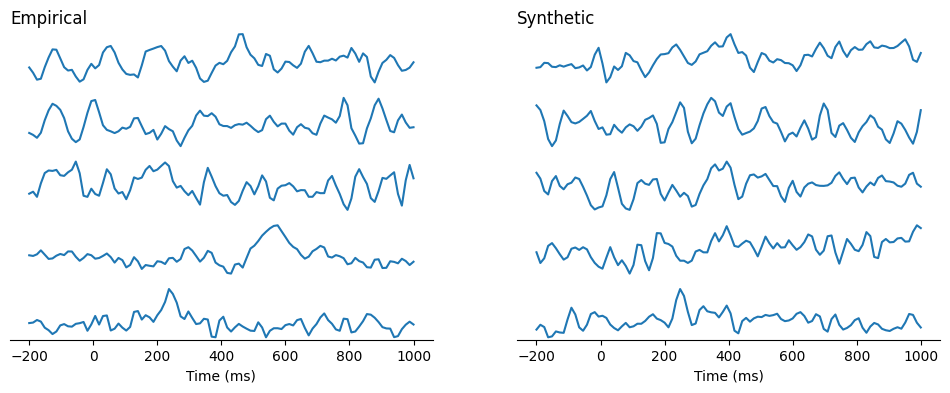

In [15]:
#Determine 5 random trials to plot
empiricalIndex = rnd.sample(range(0, empiricalEEG.shape[0]), 5)
syntheticIndex = rnd.sample(range(0, syntheticEEG.shape[0]), 5)

#Plot trial data
f, ax = plt.subplots(5, 2, figsize=(12, 4))
for c in range(5):
    ax[c,0].plot(time,empiricalEEG[empiricalIndex[c],4:]) #Note, we here add the same filter simply for visualization
    ax[c,0].set_yticks([])

    ax[c,1].plot(time,syntheticEEG[syntheticIndex[c],2:])
    ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
    ax[c,1].set_yticks([])

    if c == 0:
        ax[c,0].set_title('Empirical', loc='left')
        ax[c,1].set_title('Synthetic', loc='left')
    else:
        ax[c,0].set_title(' ')
        ax[c,1].set_title(' ')

    if c != 4:
        ax[c,0].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xticks([])
        ax[c,1].set_xticks([])
    else:
        ax[c,0].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xlabel('Time (ms)')
        ax[c,1].set_xlabel('Time (ms)')

## Step 3.2.2. View ERP Data
We will now show the empirical and synthetic ERPs side-by-side for comparison.

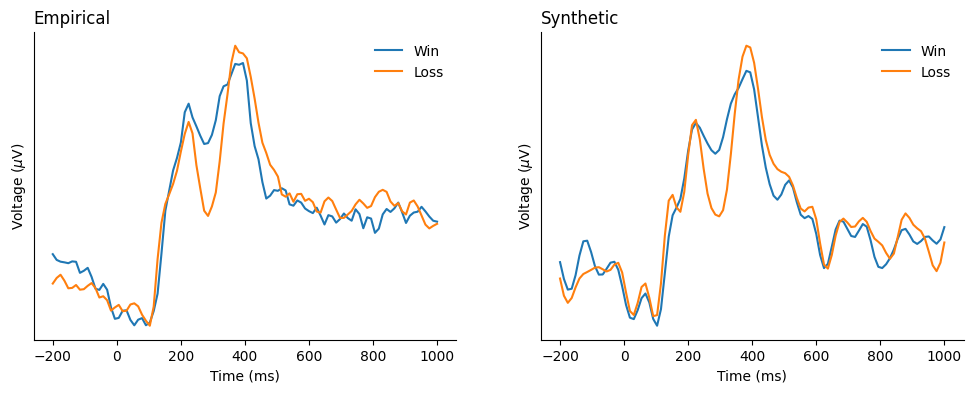

In [16]:
#Define Filter Function
def filter_synthetic(EEG, fs=83.33):
    #Bandpass
    w = [x / fs for x in [0.1, 30]]
    b, a = signal.butter(4, w, 'band')

    #Process
    filteredEEG = [signal.filtfilt(b, a, EEG[trial,:]) for trial in range(len(EEG))] #Bandpass filter

    return np.array(filteredEEG)

#Filter synthetic data
syntheticEEG[:,2:] = filter_synthetic(syntheticEEG[:,2:])

#Grand average the synthetic waveforms for each condition
synLossWaveform = np.mean(syntheticEEG[np.r_[syntheticEEG[:,0]==1],2:],axis=0)
synWinWaveform = np.mean(syntheticEEG[np.r_[syntheticEEG[:,0]==0],2:],axis=0)

#Set up figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#Plot each empirical waveform (note, we here add the same processing simply for visualization)
ax1.plot(time, scale(winWaveform), label = 'Win')
ax1.plot(time, scale(lossWaveform), label = 'Loss')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Empirical', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.tick_params(left = False, labelleft = False)
ax1.legend(frameon=False)

#Plot each synthetic waveform
ax2.plot(time, scale(synWinWaveform), label = 'Win')
ax2.plot(time, scale(synLossWaveform), label = 'Loss')

#Format plot
ax2.set_ylabel('Voltage ($\mu$V)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('Synthetic', loc='left')
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(left = False, labelleft = False)
ax2.legend(frameon=False)

# Step 4. Classification

## Step 4.1. Preparing Validation Data
We also provide a validation dataset with samples not contained in the empirical dataset. Here, we prepare them for classification.

In [17]:
#Set seed for a bit of reproducibility
rnd.seed(42)

#This function averages trial-level empirical data for each participant and condition
def averageEEG(EEG):
    participants = np.unique(EEG[:,0])
    averagedEEG = []
    for participant in participants:
        for condition in range(2):
            averagedEEG.append(np.mean(EEG[(EEG[:,0]==participant)&(EEG[:,1]==condition),:], axis=0))
    return np.array(averagedEEG)

#Load test data to predict (data that neither the GAN nor the classifier will ever see in training)
EEGDataTest = np.genfromtxt('data/eeggan_validation_example.csv', delimiter=',', skip_header=1)
EEGDataTest = averageEEG(EEGDataTest)[:,1:]

#Extract test outcome and predictor data
y_test = EEGDataTest[:,0]
x_test = EEGDataTest[:,3:]
x_test = scale(x_test,axis = 1)

## Step 4.2. Preparing Empirical Data
We now prepare the empirical training set. Our predictors will be the entire time series of 100 datapoints.

In [18]:
#Create participant by condition averages
Emp_train = averageEEG(empiricalEEG)[:,1:]

#Extract the outcomes
Emp_Y_train = Emp_train[:,0]

#Scale the predictors
Emp_X_train = scale(Emp_train[:,3:], axis=1)

#Shuffle the order of samples
trainShuffle = rnd.sample(range(len(Emp_X_train)),len(Emp_X_train))
Emp_Y_train = Emp_Y_train[trainShuffle]
Emp_X_train = Emp_X_train[trainShuffle,:]

## Step 4.3. Preparing Augmented Data
We will prepare the augmented dataset by first processing the synthetic data as we did with the empirical data, then combining both the empirical and synthetic dataset to create an augmented dataset.

In [19]:
#This function averages trial-level synthetic data in bundles of 50 trials, constrained to each condition
def averageSynthetic(synData):
    samplesToAverage = 50

    lossSynData = synData[synData[:,0]==0,:]
    winSynData = synData[synData[:,0]==1,:]

    lossTimeIndices = np.arange(0,lossSynData.shape[0],samplesToAverage)
    winTimeIndices = np.arange(0,winSynData.shape[0],samplesToAverage)

    newLossSynData = [np.insert(np.mean(lossSynData[int(trialIndex):int(trialIndex)+samplesToAverage,1:],axis=0),0,0) for trialIndex in lossTimeIndices]
    newWinSynData = [np.insert(np.mean(winSynData[int(trialIndex):int(trialIndex)+samplesToAverage,1:],axis=0),0,1) for trialIndex in winTimeIndices]

    avgSynData = np.vstack((np.asarray(newLossSynData),np.asarray(newWinSynData)))

    return avgSynData

#Create 'participant' by condition averages
Syn_train = averageSynthetic(syntheticEEG)

#Extract the outcomes
Syn_Y_train = Syn_train[:,0]

#Scale the predictors
Syn_X_train = scale(Syn_train[:,2:], axis=1)

#Combine empirical and synthetic datasets to create an augmented dataset
Aug_Y_train = np.concatenate((Emp_Y_train,Syn_Y_train))
Aug_X_train = np.concatenate((Emp_X_train,Syn_X_train))

#Shuffle the order of samples
trainShuffle = rnd.sample(range(len(Aug_X_train)),len(Aug_X_train))
Aug_Y_train = Aug_Y_train[trainShuffle]
Aug_X_train = Aug_X_train[trainShuffle,:]

# Step 5. Support Vector Machine

## Step 5.1. Define Search Space

In [20]:
#Determine SVM search space
param_grid_SVM = [
    {'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}]

## Step 5.2. Classify Empirical Data

In [21]:
#Setup tracking variable
predictionScores_SVM = []

#Setup SVM grid search
optimal_params = GridSearchCV(
    SVC(),
    param_grid_SVM,
    refit = True,
    verbose = False)

#Conduct classification
optimal_params.fit(Emp_X_train, Emp_Y_train)
SVMOutput = optimal_params.predict(x_test)

#Determine performance
predictResults = classification_report(y_test, SVMOutput, output_dict=True)
predictionScores_SVM.append(round(predictResults['accuracy']*100))

## Step 5.3. Classify Augmented Data

In [22]:
#Setup SVM grid search
optimal_params = GridSearchCV(
    SVC(random_state=42),
    param_grid_SVM,
    refit = True,
    verbose = False)

#Conduct classification
optimal_params.fit(Aug_X_train, Aug_Y_train)
SVMOutput = optimal_params.predict(x_test)

#Determine performance
predictResults = classification_report(y_test, SVMOutput, output_dict=True)
predictionScores_SVM.append(round(predictResults['accuracy']*100))

#Report results
print(f"Empirical Classification Accuracy: {str(predictionScores_SVM[0])}%")
print(f"Augmented Classification Accuracy: {str(predictionScores_SVM[1])}%")

Empirical Classification Accuracy: 53%
Augmented Classification Accuracy: 72%


# Step 6. Neural Network

## Step 6.1. Define Search Space

In [26]:
#Determine neural network search space
param_grid_NN = [
    {'hidden_layer_sizes': [(25,), (50,), (25, 25), (50,50), (50,25,50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [5000, 10000, 20000, 50000]}]

## Step 6.2. Classify Empirical Data

In [27]:
#Signify computational time
print('This may take a few minutes...')

#Setup tracking variable
predictionScores_NN = []

#Setup neural network grid search
optimal_params = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_NN,
    verbose = True,
    n_jobs = -1)

#Conduct classification
optimal_params.fit(Emp_X_train, Emp_Y_train);
neuralNetOutput = MLPClassifier(hidden_layer_sizes=optimal_params.best_params_['hidden_layer_sizes'],
                            activation=optimal_params.best_params_['activation'],
                            solver = optimal_params.best_params_['solver'],
                            alpha = optimal_params.best_params_['alpha'],
                            learning_rate = optimal_params.best_params_['learning_rate'],
                            max_iter = optimal_params.best_params_['max_iter'])
neuralNetOutput.fit(Emp_X_train, Emp_Y_train)
y_true, y_pred = y_test , neuralNetOutput.predict(x_test)

#Determine performance
predictResults = classification_report(y_true, y_pred, output_dict=True)
predictScore = round(predictResults['accuracy']*100)
predictionScores_NN.append(predictScore)

This may take a few minutes...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


## Step 6.3. Classify Augmented Data

In [28]:
#Signify computational time
print('This may take twice as long as the empirical neural network classification...')

#Setup neural network grid search
optimal_params = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_NN,
    verbose = True,
    n_jobs = -1)

#Conduct classification
optimal_params.fit(Aug_X_train, Aug_Y_train);
neuralNetOutput = MLPClassifier(hidden_layer_sizes=optimal_params.best_params_['hidden_layer_sizes'],
                            activation=optimal_params.best_params_['activation'],
                            solver = optimal_params.best_params_['solver'],
                            alpha = optimal_params.best_params_['alpha'],
                            learning_rate = optimal_params.best_params_['learning_rate'],
                            max_iter = optimal_params.best_params_['max_iter'])
neuralNetOutput.fit(Aug_X_train, Aug_Y_train)
y_true, y_pred = y_test , neuralNetOutput.predict(x_test)

#Determine performance
predictResults = classification_report(y_true, y_pred, output_dict=True)
predictScore = round(predictResults['accuracy']*100)
predictionScores_NN.append(predictScore)

#Report results
print(f"Empirical Classification Accuracy: {str(predictionScores_NN[0])}%")
print(f"Augmented Classification Accuracy: {str(predictionScores_NN[1])}%")

This may take twice as long as the empirical neural network classification...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Empirical Classification Accuracy: 49%
Augmented Classification Accuracy: 70%


# Step 7. Final Report

## Step 7.1. Present Classification Performance
We present the performance accuracies in text.

In [29]:
#Report results
print(f"{printFormat.bold}SVM Classification Results:{printFormat.end}")
print(f"Empirical Classification Accuracy: {predictionScores_SVM[0]}%")
print(f"Augmented Classification Accuracy: {predictionScores_SVM[1]}%")

# Report results
print(f"\n{printFormat.bold}Neural Network Classification Results:{printFormat.end}")
print(f"Empirical Classification Accuracy: {predictionScores_NN[0]}%")
print(f"Augmented Classification Accuracy: {predictionScores_NN[1]}%")
print(f"\n{printFormat.italic}Note: Due to randomization in this process, these accuracies will vary.{printFormat.end}")

SVM Classification Results:
Empirical Classification Accuracy: 53%
Augmented Classification Accuracy: 72%

Neural Network Classification Results:
Empirical Classification Accuracy: 49%
Augmented Classification Accuracy: 70%

Note: Due to randomization in this process, these accuracies will vary.


## Step 7.2. Plot Classification Performance
We present the performance accuracies in a plot.

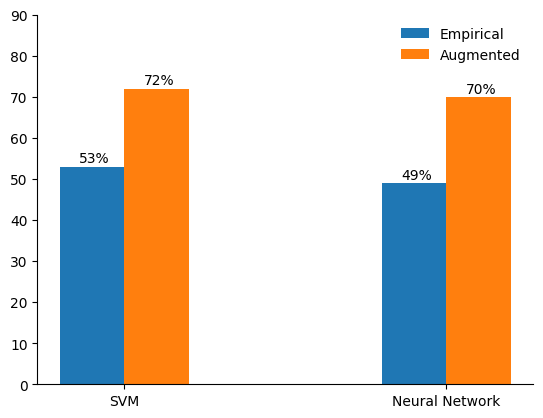

In [30]:
ax = plt.subplot(111)
plt.bar([.9,1.9],[predictionScores_SVM[0],predictionScores_NN[0]], width=.2)
plt.bar([1.1,2.1],[predictionScores_SVM[1],predictionScores_NN[1]], width=.2)
plt.ylim([0,round((np.max([predictionScores_SVM,predictionScores_NN])+20)/10)*10])
predictionScores = predictionScores_SVM+predictionScores_NN
for xi, x in enumerate([.86,1.06,1.86,2.06]):
    plt.text(x,predictionScores[xi]+1,str(predictionScores[xi])+'%')
plt.xticks([1,2], labels = ['SVM', 'Neural Network'])
plt.legend(['Empirical','Augmented'], loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)